# Variational AutoEncoders on Fashion MNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/02_vae_fashion/vae_fashion.ipynb)

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as Transforms
from torchsummary import summary

from matplotlib import pyplot as plt

## 0. Train parameters

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 128
EMBEDDING_DIM = 2
EPOCHS = 10
LEARNING_RATE = 1e-3

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [3]:
def get_dataloaders():

    # first define a transform function, to turn images into tersors
    transform = Transforms.Compose([
                    Transforms.ToTensor(),
                    Transforms.Pad(2)])

    # load MNIST dataset
    train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=transform)
    test_ds = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                         download=True, transform=transform)
    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4)
    return train_loader, test_loader

In [4]:
train_loader, test_loader = get_dataloaders()
print(next(iter(train_loader))[0].shape)

torch.Size([128, 1, 32, 32])


## 2. Build the AutoEncoder

In [5]:
# Encoder
class Encoder(nn.Module):

    def __init__(self, latents):
        super().__init__()
        self.latents = latents
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            # nn.Linear(in_features=2048, out_features=self.latents)
        )

        self.mean = nn.Linear(in_features=2048, out_features=self.latents)
        self.logvar = nn.Linear(in_features=2048, out_features=self.latents)
    
    def forward(self, x):
        x = self.model(x)
        mean_x = self.mean(x)
        logvar_x = self.logvar(x)
        return mean_x, logvar_x

# encoder = Encoder(EMBEDDING_DIM).to(DEVICE)
# summary(encoder, (1, 32, 32))

# Decoder
class Decoder(nn.Module):
    
    def __init__(self, latents):
        super().__init__()
        self.latents = latents
        self.fc = nn.Linear(self.latents, 2048)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                   kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.model(x)
        return x

# decoder = Decoder(EMBEDDING_DIM).to(DEVICE)
# summary(decoder, (EMBEDDING_DIM,))

In [6]:
# Variational AutoEncoder
class VAE(nn.Module):
    def __init__(self, latents):
        super().__init__()
        self.encoder = Encoder(latents)
        self.decoder = Decoder(latents)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z)      
        return recon_x, mean, logvar

    def generate(self, z):
        return F.sigmoid(self.decoder(z))

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(DEVICE)
        eps = torch.randn(size=logvar.shape).to(DEVICE)      
        return mean + std * eps

vae = VAE(EMBEDDING_DIM).to(DEVICE)
summary(vae, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
            Linear-9                    [-1, 2]           4,098
          Encoder-10         [[-1, 2], [-1, 2]]               0
           Linear-11                 [-1, 2048]           6,144
  ConvTranspose2d-12            [-1, 128, 8, 8]         147,584
             ReLU-13            [-1, 128, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

## 3. Define the model, objective, and optimizer

In [14]:
def kl_divergence(mean, logvar):
    loss = -0.5 * (1 + logvar - torch.square(mean) - torch.exp(logvar)).sum(axis=1)
    return loss.mean()

vae = VAE(EMBEDDING_DIM).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    vae = torch.compile(vae) # PyTorch 2.0 feature
    print('model compiled')

bce_loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
kl_loss_fn = kl_divergence
optim = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)

model compiled


## 4. Get dataloaders

In [15]:
train_loader, test_loader = get_dataloaders()

## 5. Define train and validation functions

In [16]:
# A single epoch train funcion
def train(model, dataloader, optimizer, bce_loss_fn, kl_loss_fn):

    model.train()
    running_bce_loss = 0
    running_kl_loss = 0

    for i, (train_x, train_y) in enumerate(dataloader):
        optimizer.zero_grad()
        train_x = train_x.to(DEVICE)
        recon_x, mean, logvar = model(train_x)
        bce_loss = bce_loss_fn(recon_x, train_x)
        kl_loss = kl_loss_fn(mean, logvar)
        loss = bce_loss + kl_loss * 3e-3
        loss.backward()
        optimizer.step()

        running_bce_loss += bce_loss.item()
        running_kl_loss += kl_loss.item()

    return running_bce_loss / len(dataloader), running_kl_loss / len(dataloader)

# Validation function
def validate(model, dataloader, bce_loss_fn, kl_loss_fn):
    
    model.eval()
    running_bce_loss = 0
    running_kl_loss = 0
    
    for i, (test_x, test_y) in enumerate(dataloader):
        test_x = test_x.to(DEVICE)
        with torch.no_grad():
            recon_x, mean, logvar = model(test_x)
            bce_loss = bce_loss_fn(recon_x, test_x)
            kl_loss = kl_loss_fn(mean, logvar)

        running_bce_loss += bce_loss.item()
        running_kl_loss += kl_loss.item()

    return running_bce_loss / len(dataloader), running_kl_loss / len(dataloader)

## 6. Train and evaluate

In [17]:
for i in range(EPOCHS):
    train_bce_loss, train_kl_loss = train(vae, train_loader, optim, bce_loss_fn, kl_loss_fn)
    test_bce_loss, test_kl_loss = validate(vae, test_loader, bce_loss_fn, kl_loss_fn)

    print(f'Epoch {i + 1}')
    print(f'\tTrain - bce_loss: {train_bce_loss:.4f}, kl_loss: {train_kl_loss:.4f}')
    print(f'\tValid - bce_loss: {test_bce_loss:.4f}, kl_loss: {test_kl_loss:.4f}')

[2023-06-10 15:01:24,510] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-06-10 15:01:29,062] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-06-10 15:01:29,720] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-06-10 15:01:30,530] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch 1
	Train - bce_loss: 0.2945, kl_loss: 4.4654
	Valid - bce_loss: 0.2618, kl_loss: 4.8034
Epoch 2
	Train - bce_loss: 0.2580, kl_loss: 5.0143
	Valid - bce_loss: 0.2590, kl_loss: 4.9970
Epoch 3
	Train - bce_loss: 0.2553, kl_loss: 5.1201
	Valid - bce_loss: 0.2553, kl_loss: 5.1870
Epoch 4
	Train - bce_loss: 0.2537, kl_loss: 5.2043
	Valid - bce_loss: 0.2544, kl_loss: 5.3355
Epoch 5
	Train - bce_loss: 0.2526, kl_loss: 5.2665
	Valid - bce_loss: 0.2530, kl_loss: 5.4112
Epoch 6
	Train - bce_loss: 0.2518, kl_loss: 5.2984
	Valid - bce_loss: 0.2528, kl_loss: 5.2815
Epoch 7
	Train - bce_loss: 0.2511, kl_loss: 5.3364
	Valid - bce_loss: 0.2528, kl_loss: 5.2633
Epoch 8
	Train - bce_loss: 0.2505, kl_loss: 5.3869
	Valid - bce_loss: 0.2519, kl_loss: 5.3920
Epoch 9
	Train - bce_loss: 0.2502, kl_loss: 5.4019
	Valid - bce_loss: 0.2527, kl_loss: 5.1407
Epoch 10
	Train - bce_loss: 0.2497, kl_loss: 5.4346
	Valid - bce_loss: 0.2511, kl_loss: 5.4201


## 7. Reconstruct using the `Variational AutoEncoder`

In [20]:
def plot_imgs(imgs, cmap='gray'):
    plt.figure(figsize=(20, 3))
    num_img = imgs.shape[0]

    for i in range(num_img):
        plt.subplot(1, num_img, i + 1)
        plt.axis('off')
        plt.imshow(imgs[i], cmap=cmap)

    plt.show()

In [22]:
num_samples = 5000
num_iters = np.ceil(num_samples / BATCH_SIZE).astype(int)

# Get samples
for i, (test_x, test_y) in enumerate(test_loader):
    
    if i == 0:
        batch_samples = test_x
        batch_labels = test_y
    else:
        batch_samples = torch.concatenate([batch_samples, test_x])
        batch_labels = torch.concatenate([batch_labels, test_y])
    if i == num_iters - 1: break

batch_samples = batch_samples.to(DEVICE)
with torch.no_grad():
    recon_x, mean, logvar = vae(batch_samples)

[2023-06-10 15:09:24,863] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Original Images:


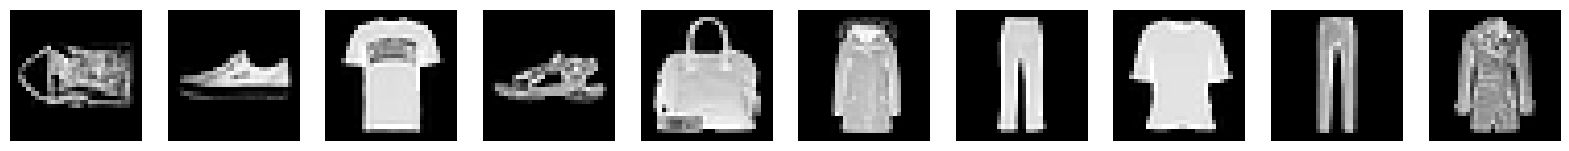

Reconstructed Images:


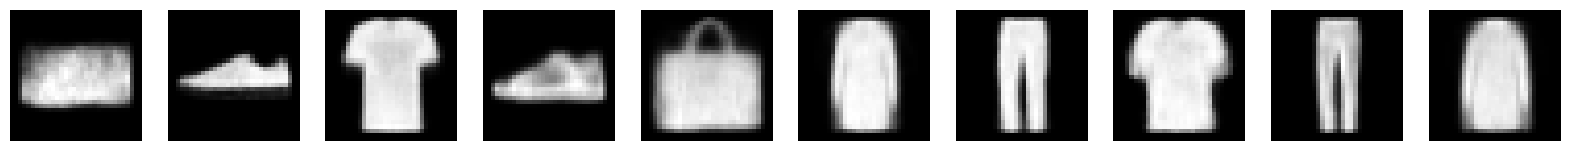

In [30]:
# randomly sample 10 images from the original set and reconstructed set
img_choices = np.random.choice(num_samples, size=10)
original_imgs = batch_samples[img_choices].permute(0, 2, 3, 1)
recons_imgs = F.sigmoid(recon_x[img_choices]).permute(0, 2, 3, 1)

print('Original Images:')
plot_imgs(original_imgs.detach().cpu().numpy())

print('Reconstructed Images:')
plot_imgs(recons_imgs.detach().cpu().numpy())

## 8. Embed using `Encoder`

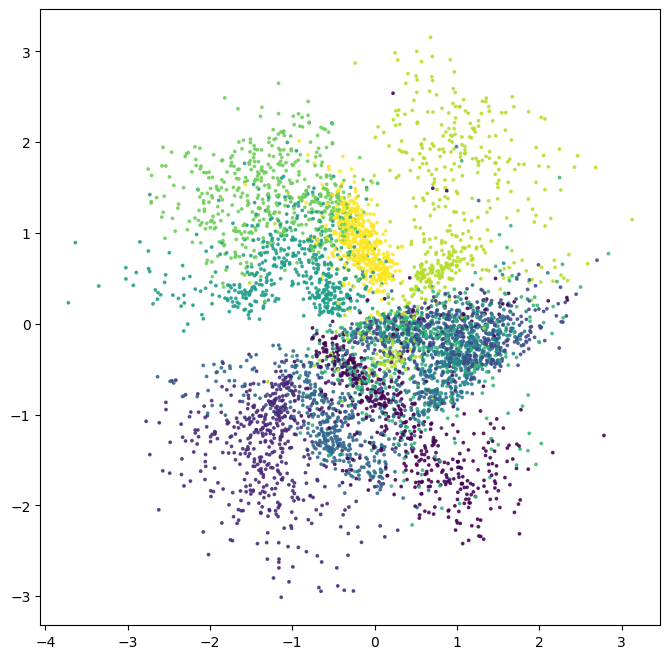

In [31]:
num_samples = 5000
num_iters = np.ceil(num_samples / BATCH_SIZE).astype(int)

with torch.no_grad():
    mean, logvar = vae.encoder(batch_samples)
    output_embs = vae.reparameterize(mean, logvar)
output_labels = batch_labels

output_embs = output_embs.detach().cpu().numpy()
output_labels = output_labels.detach().cpu().numpy()

plt.figure(figsize=(8, 8))
plt.scatter(output_embs[:, 0], 
            output_embs[:, 1], 
            c=output_labels, 
            alpha=0.8,
            s=3)
plt.show()

## 9 Generate using `Decoder`

In [32]:
# # Sampling from the embedding space
# x_min, x_max = output_embs[:, 0].min(), output_embs[:, 0].max()
# y_min, y_max = output_embs[:, 1].min(), output_embs[:, 1].max()

# xs = np.random.uniform(x_min, x_max, size=(18, 1))
# ys = np.random.uniform(y_min, y_max, size=(18, 1))
# samples = np.hstack([xs, ys])

# samples_torch = torch.tensor(samples, device=DEVICE, dtype=torch.float32)
# # print(samples.shape)

# output_imgs = vae.generate(samples_torch).detach().cpu().numpy()
# output_imgs = output_imgs.transpose((0, 2, 3, 1))

# plt.figure(figsize=(6, 6))
# plt.scatter(output_embs[:, 0], 
#             output_embs[:, 1], 
#             c='black', 
#             alpha=0.5,
#             s=3)
# plt.scatter(samples[:, 0], 
#             samples[:, 1], 
#             c='red', 
#             alpha=0.5,
#             s=20)
# plt.show()

# # Generate new images from sampled embeddings
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(10, 6))
# for i in range(output_imgs.shape[0]):
#     curr_row = i // 6
#     curr_col = i % 6
#     ax = axes[curr_row, curr_col]
    
#     ax.set_title(f'({samples[i][0]:.1f}, {samples[i][1]:.1f})')
#     ax.axis('off')
#     ax.imshow(output_imgs[i], cmap='gray')

# plt.show()